# 👥costumer invitation project

### 📝Project Overview
This project aims to build a classification model to predict whether customers will accept a promotional offer, using historical marketing data.  
The dataset includes demographic and financial information, already standardized and encoded.  
Several models will be evaluated to recommend the best approach for targeting potential customers.


### 1-importing required libraries

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import f1_score

### 2-loading the dataset
first I load the dataset from the marketing_campaign.xlsx file into a DataFrame called df and display the first five rows to verify it loaded correctly.

In [18]:
import pandas as pd
df = pd.read_excel("marketing_campaign.xlsx")
df.head()

,age,default,balance,housing,loan,day,duration,y
0,1.606965,0,0.256419,1,0,-1.298476,0.011016,0
1,0.288529,0,-0.437895,1,0,-1.298476,-0.416127,0
2,-0.747384,0,-0.446762,1,1,-1.298476,-0.707361,0
3,0.571051,0,0.047205,1,0,-1.298476,-0.645231,0
4,-0.747384,0,-0.447091,0,0,-1.298476,-0.233620,0


### 3-cheking my dataset values
In this cell, I perform an initial exploration of the dataset to understand its structure and check for potential issues.

df.info(): Provides a technical summary of the DataFrame, including the data types of each column and memory usage.

df['y'].value_counts(): Counts the occurrences of each class in the target variable y ('0' for No, '1' for Yes). This is a critical step to check for class imbalance.

In [19]:
df.info()
print(df['y'].value_counts()) 

# counting classes
y_counts = df['y'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       45211 non-null  float64
 1   default   45211 non-null  int64  
 2   balance   45211 non-null  float64
 3   housing   45211 non-null  int64  
 4   loan      45211 non-null  int64  
 5   day       45211 non-null  float64
 6   duration  45211 non-null  float64
 7   y         45211 non-null  int64  
dtypes: float64(4), int64(4)
memory usage: 2.8 MB
y
0    39922
1     5289
Name: count, dtype: int64


### 📊4-plotting class distribution
Bar Chart: I then use matplotlib to create a bar chart that visually displays the class distribution, making it easy to see the imbalance between customers who accepted the offer and those who did not.

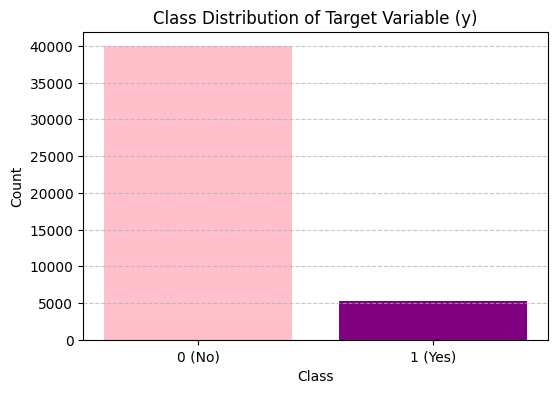

In [20]:
# plotting
plt.figure(figsize=(6,4))
plt.bar(y_counts.index.astype(str), y_counts.values, color=['pink', 'purple'])

plt.title('Class Distribution of Target Variable (y)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['0 (No)', '1 (Yes)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 3-Feature Selection and Data Splitting
Before training a model, we need to define our input features and our target variable, and then split our data into training and testing sets.

Feature Selection: I create my feature matrix X by selecting the relevant columns from the DataFrame: age, default, balance, housing, loan, day, and duration. Our target vector 

y is the column representing the customer's decision. 

In [21]:
X = np.asanyarray(df[["age","default","balance","housing","loan","day","duration"]])
y = np.asanyarray(df[["y"]])

Data Splitting: I use scikit-learn's train_test_split function to divide the data. This is a critical step to ensure we can evaluate our model's performance on data it has never seen before.

test_size=0.2: This allocates 20% of the data to the test set and the remaining 80% to the training set.

stratify=y: This ensures that the proportion of positive and negative outcomes in both the training and test sets mirrors that of the original dataset. This is crucial for handling imbalanced data.

In [22]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y, random_state=42)

To establish a performance baseline, I first trained a Logistic Regression model on the original, imbalanced data and evaluated its accuracy and F1 Score before applying any resampling techniques

In [23]:
model = LogisticRegression()
model.fit(X_train, y_train.ravel())

LogisticRegression()

In [24]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
y_pred = model.predict(X_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8856574145748093
Precision: 0.5395
Recall: 0.1550
F1 Score: 0.2408


### 4-Balancing the Training Data with SMOTE
Problem: A significant class imbalance was found (39,922 'No' vs. 5,289 'Yes'), which can bias the model.

Solution: We apply SMOTE (Synthetic Minority Over-sampling Technique) to the training data only.

Outcome: This creates a new, balanced training set (X_train_smote, y_train_smote) by generating synthetic samples for the underrepresented 'Yes' class.

In [25]:
smote = SMOTE(random_state=42)
print(f"before resampling trainig set counts: {Counter(y_train.ravel())}")
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"resampled trainig set counts: {Counter(y_train_smote)}")

before resampling trainig set counts: Counter({np.int64(0): 31937, np.int64(1): 4231})
resampled trainig set counts: Counter({np.int64(0): 31937, np.int64(1): 31937})


### 5-Optimizing the Random Forest Model
After an initial review, the Random Forest model showed strong potential. To ensure we get the best possible results from it, we decided to perform hyperparameter tuning before our final model comparison.

Objective: To find the optimal settings for the Random Forest to maximize its performance.

Method: We use RandomizedSearchCV to automatically test various combinations of model parameters.

Goal: The search is configured to find the settings that result in the highest possible F1 Score.

Outcome: This process will identify the best-performing set of parameters, which we will then use to create our final, optimized Random Forest model for the comparison.

In [33]:
from sklearn.model_selection import RandomizedSearchCV

# 1. Define the grid of hyperparameters to test
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

# 2. Create a new Random Forest model instance
rf = RandomForestClassifier(random_state=42)

# 3. Set up the Randomized Search
#    n_iter=20 means it will test 20 different combinations
#    cv=3 means it will use 3-fold cross-validation
#    scoring='f1' tells it to optimize for the F1 score
rand_search = RandomizedSearchCV(estimator=rf,
                                 param_distributions=param_dist,
                                 n_iter=20,
                                 cv=3,
                                 verbose=2,
                                 random_state=42,
                                 n_jobs=-1, # Use all available CPU cores
                                 scoring='f1')

# 4. Fit the random search to the SMOTE-balanced training data
print("Starting hyperparameter search...")
rand_search.fit(X_train_smote, y_train_smote.ravel())

# 5. Print the best parameters and the best score
print("\n--- Search Complete ---")
print(f"Best Parameters found: {rand_search.best_params_}")
print(f"Best F1 Score from search: {rand_search.best_score_:.4f}")

Starting hyperparameter search...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

--- Search Complete ---
Best Parameters found: {'n_estimators': 300, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': None}
Best F1 Score from search: 0.9083


### 6-function for plotting confusion matrix
Purpose: This helper function uses seaborn to create a styled heatmap of a model's confusion matrix.

Inputs: It takes the true labels (y_true), the model's predictions (y_pred), and a model name for the title.

Output: A plot with a pink color scheme (cmap='RdPu') and numerical annotations for easy interpretation of the results.

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, model_name):
    """
    Plots a confusion matrix for a given model's predictions.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    # Define the figure size and labels
    plt.figure(figsize=(6, 4))
    
    # Create the heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu', 
                xticklabels=['Predicted No', 'Predicted Yes'], 
                yticklabels=['Actual No', 'Actual Yes'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

### 🎯6-Final Model Training and Comparison
This cell automates the final stage of the project: systematically training and evaluating every selected model to find the best performer.

The process follows these steps:

Model Dictionary: A dictionary named models is created to hold all the classifiers for the final comparison. This includes the optimized Random Forest using the best-performing parameters found during the tuning phase,logistic regression,KNN,LDA,QDA,LGBM.

Iterative Training: The script then loops through each model in the dictionary.

Evaluation Process: Inside the loop, each model is trained on the balanced SMOTE data, and its training time is recorded. The model's performance is then immediately evaluated by making predictions on the untouched test set.

Results Compilation: The final Precision, Recall, and F1 Score are calculated and stored for each model. After the loop finishes, these results are presented in a single pandas DataFrame for a clear, side-by-side comparison.

🚀 Training Logistic Regression...


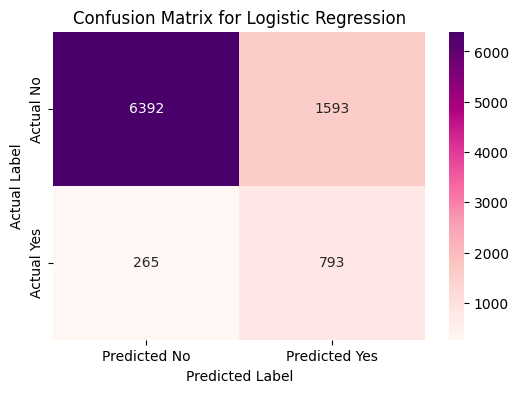

🚀 Training K-Nearest Neighbors...


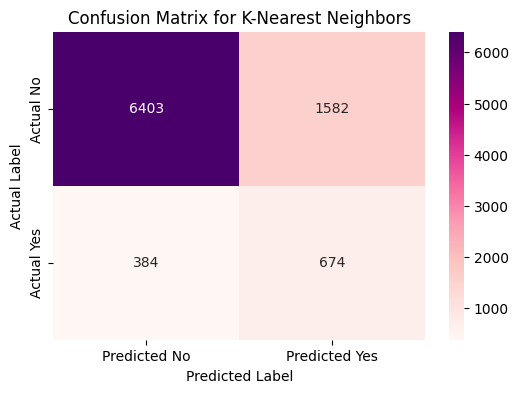

🚀 Training Linear Discriminant Analysis...


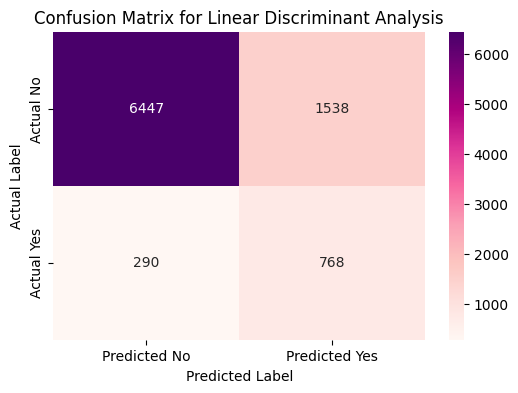

🚀 Training Quadratic Discriminant Analysis...


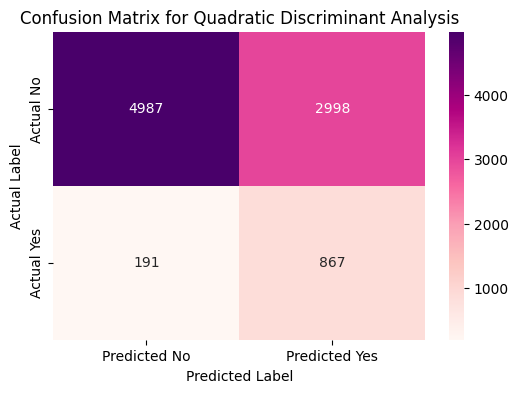

🚀 Training LightGBM...
[LightGBM] [Info] Number of positive: 31937, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1582
[LightGBM] [Info] Number of data points in the train set: 63874, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


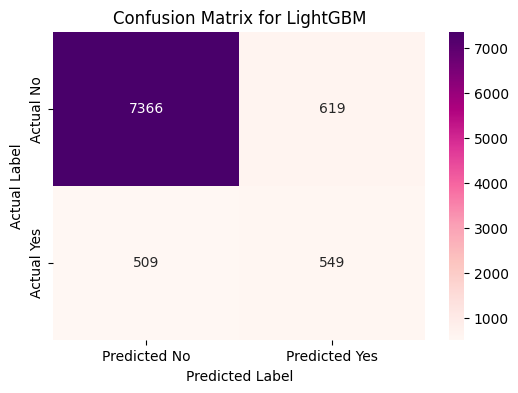

🚀 Training Random Forest...


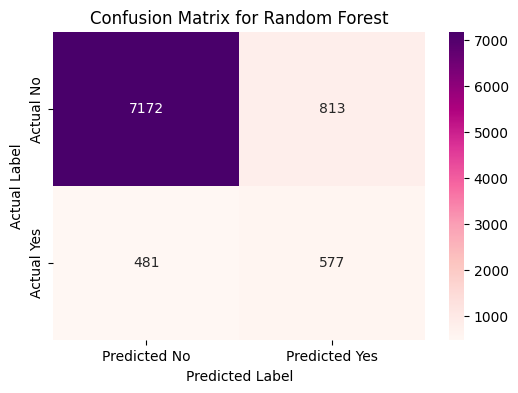

🚀 Training Support Vector Machine...


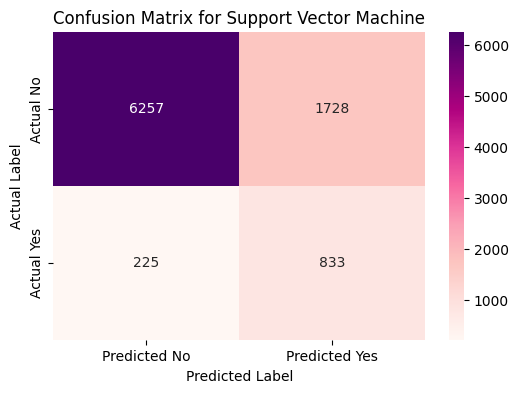


--- Model Comparison ---
                             Model  Precision    Recall  F1 Score  \
0              Logistic Regression   0.332355  0.749527  0.460511   
1              K-Nearest Neighbors   0.298759  0.637051  0.406759   
2     Linear Discriminant Analysis   0.333044  0.725898  0.456599   
3  Quadratic Discriminant Analysis   0.224321  0.819471  0.352224   
4                         LightGBM   0.470034  0.518904  0.493261   
5                    Random Forest   0.415108  0.545369  0.471405   
6           Support Vector Machine   0.325264  0.787335  0.460348   

   Training Time (s)  accuracy  
0           0.146127  0.794537  
1           0.757128  0.782594  
2           0.140306  0.797855  
3           0.131804  0.647352  
4           0.489997  0.875263  
5          26.555044  0.856906  
6         139.691360  0.784032  


In [32]:
from sklearn.preprocessing import StandardScaler # Import the scaler
from sklearn.pipeline import Pipeline # Import the pipeline tool
import lightgbm as lgb
from sklearn.svm import SVC
import time
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Quadratic Discriminant Analysis": QuadraticDiscriminantAnalysis(),
    "LightGBM": lgb.LGBMClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300,min_samples_split=2,max_features='sqrt',max_depth=None,random_state=42),
    "Support Vector Machine": SVC(C=1.0, gamma='scale', random_state=42)
}

results = []

for name, model in models.items():
    print(f"🚀 Training {name}...")
    start_time = time.time()

    # Create a pipeline that first scales the data, then trains the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    # Train the pipeline on the SMOTE-balanced training data
    pipeline.fit(X_train_smote, y_train_smote.ravel())

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)

    # Plot the confusion matrix
    plot_confusion_matrix(y_test, y_pred, name)

    # Calculate performance metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    end_time = time.time()

    results.append({
        "Model": name,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Training Time (s)": end_time - start_time,
        "accuracy" : accuracy_score(y_test, y_pred)
    })

# Convert the list of results into a DataFrame and display it
results_df = pd.DataFrame(results)
print("\n--- Model Comparison ---")
print(results_df)

### 🧠7-using a neural network

This cell trains and evaluates a Neural Network (MLPClassifier) to establish its performance on the classification task.

Model Definition: A Neural Network with two hidden layers is defined within the models dictionary.

Pipeline: A Pipeline is used to first apply StandardScaler to the data before passing it to the classifier. This is a crucial step for neural networks.

Training: The model is trained on the balanced SMOTE data.

Evaluation: The trained model's performance is measured on the untouched test set using Precision, Recall, and F1 Score.

Output: The final results are stored and displayed in a DataFrame for analysis.

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Model
from sklearn.neural_network import MLPClassifier


print("🚀 Starting Neural Network Training and Evaluation...")

# 1. Define the Neural Network m
model_name = "Neural Network"
neural_network = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

# 2. Create a pipeline that scales the data then trains the model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', neural_network)
])

# 3. Train the pipeline
print(f"--- Training {model_name} ---")
start_time = time.time()
pipeline.fit(X_train_smote, y_train_smote.ravel())
end_time = time.time()
training_time = end_time - start_time
print(f"Training complete in {training_time:.2f}s.")

# 4. Make predictions on the test set
y_pred = pipeline.predict(X_test)

# 5. Calculate and display performance metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("\n--- Final Model Performance ---")
print(f"Model: {model_name}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# 6. Display results in a DataFrame
results_df = pd.DataFrame([{
    "Model": model_name,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "Accuracy": accuracy,
    "Training Time (s)": training_time
}])

print("\n--- Results Summary ---")
print(results_df)

🚀 Starting Neural Network Training and Evaluation...
--- Training Neural Network ---
Training complete in 174.64s.

--- Final Model Performance ---
Model: Neural Network
Precision: 0.3420
Recall: 0.6616
F1 Score: 0.4509
Accuracy: 0.8115

--- Results Summary ---
            Model  Precision    Recall  F1 Score  Accuracy  Training Time (s)
0  Neural Network   0.341964  0.661626  0.450886  0.811456         174.640263
